In [ ]:
!pip install --upgrade mesa
!pip install --upgrade networkx[default]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mesa
import networkx as nx
import pytz

In [5]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Move to dataset folder
%cd /content/drive/MyDrive/Colab Notebooks/DSA3101/Data

/content/drive/MyDrive/Colab Notebooks/DSA3101/Data


In [7]:
df = pd.read_csv('dsa_data.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.dropna(subset = ['User Number'], inplace=True)
df = df[(df['Direction']=='Entry') | (df['Direction'] == 'Exit')]
sgt_timezone = pytz.timezone('Asia/Singapore')
df['Datetime'] = df['Datetime'].dt.tz_convert(sgt_timezone)
df['Entry'] = df['Direction'].replace({'Entry':1, 'Exit':-1})
new_df = df.sort_values('Datetime')
new_df

<ipython-input-7-0bb83e68a1be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = df['Datetime'].dt.tz_convert(sgt_timezone)


,Datetime,User Number,Broad Category,Library,Method,Direction,Entry
0,2023-01-25 07:29:13+08:00,2483.0,Library Professional,Central Library,Card,Entry,1
1,2023-01-25 07:32:15+08:00,4372.0,Library Professional,Central Library,Card,Entry,1
2,2023-01-25 07:32:35+08:00,2.0,Others,Central Library,Card,Entry,1
3,2023-01-25 07:32:45+08:00,7405.0,Others,Central Library,Card,Entry,1
4,2023-01-25 07:32:49+08:00,2182.0,Others,Central Library,Card,Entry,1
...,...,...,...,...,...,...,...
127874,2023-04-29 17:00:52+08:00,7423.0,Library Professional,Central Library,Card,Exit,-1
127913,2023-04-29 17:36:09+08:00,6427.0,Undergraduate,Central Library,Card,Entry,1
127914,2023-04-29 17:37:28+08:00,4318.0,Administrative Staff,Central Library,Card,Entry,1
127917,2023-04-29 17:38:18+08:00,4318.0,Administrative Staff,Central Library,Card,Exit,-1


In [8]:
unique_broad_categories = new_df['Broad Category'].unique()
unique_broad_categories

array(['Library Professional', 'Others', 'Teaching Staff', 'Postgraduate',
       'Undergraduate', 'Special Student', 'Administrative Staff', nan,
       'Research Staff', 'External Members/Alumni', 'Complimentary',
       'SCALE Students', 'Non-Academic Staff', 'External Members',
       'Corporate Card'], dtype=object)

In [22]:
class LibraryUser(mesa.Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.ID = unique_id
    self.timestamps = {'entry': [], 'exit': []}
    self.seat_type_preference = 'seat_type_preference'
    self.leave_willingness = True
    self.timestepsl = np.random.uniform(1,20)
    self.chosen_seat = None
    self.satisfaction = 0


    '''
    self.section_preference = 'section_preference'
    self.year = 0
    self.level_pref = 0
    self.privacy_pref = 0
    self.crowd_level_pref = 0
    self.comfort_pref = 0
    self.scenery_pref = 0
    self.lighting_pref = 0
    self.ease_find_pref = 0
    self.isalone = True
    self.gate
    '''

  def step(self):
    if self.leave_willingness:
      self.model.schedule.remove(self)
    elif self.timesteps > 0:
        self.timesteps -= 1
    else:
        self.model.schedule.remove(self)
        # TODO: remove from grid/network

In [10]:
def compute_agents(model):
    return len(model.schedule.agents)

class LibModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, entry_df):
        self.schedule = mesa.time.RandomActivation(self)
        self._curr_step = 0
        self.entry_dist = entry_df.to_dict()['Direction']
        self.total_steps = len(self.entry_dist) # total steps taken
        self.datacollector = mesa.DataCollector(
            model_reporters={"num_agents": compute_agents},
        )

    def step(self):
        self.datacollector.collect(self)
        # Create agents, where number of agents follows Poisson distribution
        num_agents = self.entry_dist[self._curr_step]
        for i in range(np.random.poisson(num_agents)):
            agent = LibAgent(f'{self._curr_step}-{i}', self)
            # print(agent.unique_id, 'created!') # for debugging
            self.schedule.add(agent) # add to schedule
        self.schedule.step()
        self._curr_step += 1

    def run(self):
        for i in range(self.total_steps):
            self.step()



In [20]:
# Create an empty graph
library_graph = nx.Graph()
#areas need put sections of different levels?
library_graph.add_node("section a", level = 3, capacity=100, seat_type = "any", privacy = 0, comfort = 0, crowd = 0, scenery = 0, lighting = 0, ease_of_finding = 0)
library_graph.add_node("section b", level = 4, capacity=100, seat_type = "any", privacy = 0, comfort = 0, crowd = 0, scenery = 0, lighting = 0, ease_of_finding = 0)
library_graph.add_node("section c", level = 5, capacity=100, seat_type = "any", privacy = 0, comfort = 0, crowd = 0, scenery = 0, lighting = 0, ease_of_finding = 0)
library_graph.add_node("section d", level = 6, capacity=100, seat_type = "any", privacy = 0, comfort = 0, crowd = 0, scenery = 0, lighting = 0, ease_of_finding = 0)
#edges
library_graph.add_edge("section a", "section b")

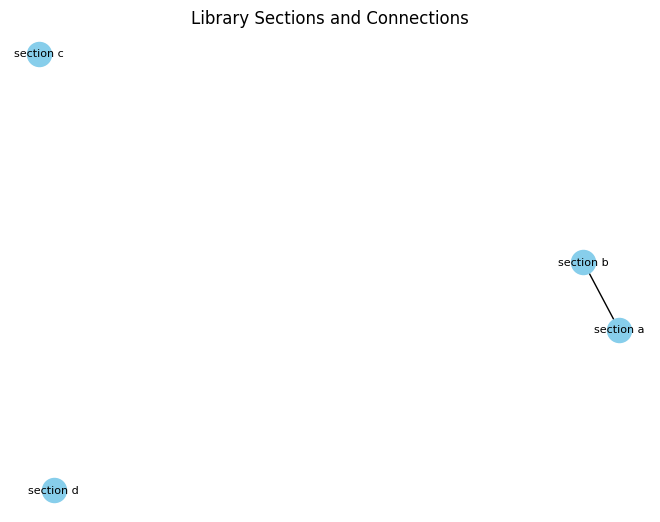

In [21]:
pos = nx.spring_layout(library_graph)
nx.draw(library_graph, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=8)
plt.title("Library Sections and Connections")
plt.show()